In [106]:
import pandas as pd
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import time
import scipy.cluster.hierarchy as sch

from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from matplotlib import rcParams
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, roc_auc_score, roc_curve, average_precision_score
import sklearn.neural_network
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv1D, MaxPooling1D

In [2]:
data_full = pd.read_csv("data_full.csv",sep=",",header=0, encoding='UTF-8', error_bad_lines=False)

b'Skipping line 81814: expected 16 fields, saw 17\nSkipping line 81952: expected 16 fields, saw 17\nSkipping line 82218: expected 16 fields, saw 17\nSkipping line 82237: expected 16 fields, saw 17\nSkipping line 82255: expected 16 fields, saw 17\nSkipping line 84268: expected 16 fields, saw 17\nSkipping line 84274: expected 16 fields, saw 17\nSkipping line 84700: expected 16 fields, saw 17\nSkipping line 85451: expected 16 fields, saw 17\nSkipping line 86072: expected 16 fields, saw 17\nSkipping line 86193: expected 16 fields, saw 17\nSkipping line 86215: expected 16 fields, saw 17\nSkipping line 86318: expected 16 fields, saw 17\nSkipping line 86527: expected 16 fields, saw 17\nSkipping line 86646: expected 16 fields, saw 17\nSkipping line 86699: expected 16 fields, saw 17\nSkipping line 86847: expected 16 fields, saw 17\nSkipping line 86913: expected 16 fields, saw 17\nSkipping line 87030: expected 16 fields, saw 17\nSkipping line 87066: expected 16 fields, saw 17\nSkipping line 8723

In [12]:
data_full.genre.value_counts()

Rock          11921
Jazz           9440
Pop            9386
Electronic     9376
Classical      9256
Rap            9232
Reggae         8771
Country        8664
Opera          8280
Metal          6275
Name: genre, dtype: int64

In [17]:
#transformation of attributes: key, mode and time signature
print(data_full['time_signature'].unique().tolist())
print(data_full['mode'].unique().tolist())
print(data_full['key'].unique().tolist())

data_full['time_signature'] = data_full['time_signature'].apply(lambda x : int(x[0]))

mode_dict = {'Major' : 1, 'Minor' : 0}
data_full['mode'].replace(mode_dict, inplace=True)


key_dict = {'C' : 0, 'C#' : 1, 'D' : 2, 'D#' : 3, 'E' : 4, 'F' :5, 'F#' : 6, 'G' : 7, 'G#' : 8, 'A' : 9, 'A#' : 10, 'B' : 11}
data_full['key'] = data_full['key'].replace(key_dict).astype(int)


['4/4', '3/4', '5/4', '1/4', '0/4']
['Major', 'Minor']
['G#', 'G', 'B', 'D', 'C', 'A#', 'F#', 'E', 'A', 'D#', 'C#', 'F']


In [19]:
#checking nulls 
data_full.isna().sum().sum()

0

In [20]:
#poszukiwanie duplikatów- wszystkich oraz pojedynczych reprezentantów 
duplicated_all = data_full[data_full.duplicated(subset = 'track_id', keep=False)]
duplicated = data_full[data_full.duplicated(subset = 'track_id', keep='first')]
print(f'''Number of unique values in duplicates: {duplicated.shape[0]}
Number of all duplicates: {duplicated_all.shape[0]}
Total number of records: {data_full.shape[0]}
% of duplicates in whole dataset: {round(duplicated_all.shape[0]/data_full.shape[0]*100, 2)}''')

Number of unique values in duplicates: 8824
Number of all duplicates: 17271
Total number of records: 90601
% of duplicates in whole dataset: 19.06


In [22]:
#drop of duplicates- it introduce confusion during music classification 
data_full=data_full.drop_duplicates(subset = 'track_id')

In [24]:
#frequency of each category in order to eliminate too small datasets
genre_count=pd.DataFrame(data_full.genre.value_counts())
genre_count.reset_index(level=0, inplace=True)
genre_count.rename(columns ={"index":"genre_name"}, inplace=True)
genre_count                    

,genre_name,genre
0,Electronic,9376
1,Classical,8867
2,Rock,8835
3,Reggae,8759
4,Jazz,8654
5,Opera,8280
6,Country,7727
7,Pop,7706
8,Rap,7521
9,Metal,6052


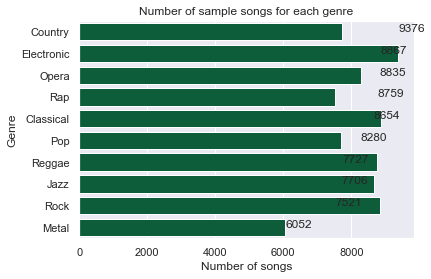

In [30]:
sns.set(style="darkgrid")
sns.countplot(y="genre", data=data_full, color='#006a3c')
plt.title('Number of sample songs for each genre')
plt.xlabel('Number of songs')
plt.ylabel('Genre')
 

for index, value in enumerate(genre_count['genre']):
     plt.text(value, index, str(value))
#plt.savefig('fig1.png', bbox_inches='tight')
plt.show()


In [27]:
#distribution of samples 
genre_percent= pd.DataFrame(data_full['genre'].value_counts()/len(data_full))
genre_percent

,genre
Electronic,0.114653
Classical,0.108429
Rock,0.108038
Reggae,0.107108
Jazz,0.105824
Opera,0.101251
Country,0.094489
Pop,0.094232
Rap,0.091970
Metal,0.074006


In [35]:
features_all=['acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence']

features=['acousticness',
       'danceability', 'duration_ms', 'instrumentalness', 'key',
       'liveness', 'loudness','mode', 'speechiness', 'tempo',
       'time_signature', 'valence']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023488EDDD48>,
      dtype=object)

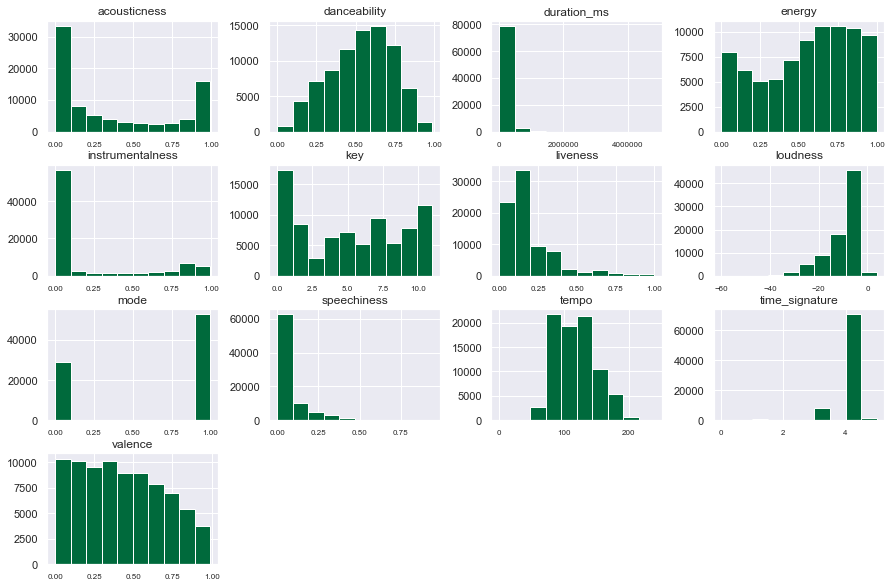

In [33]:
#histogramy cech
data_full[features_all].hist(xlabelsize=8, figsize=(15,10), color='#006a3c')
#plt.savefig('fig2.png') 

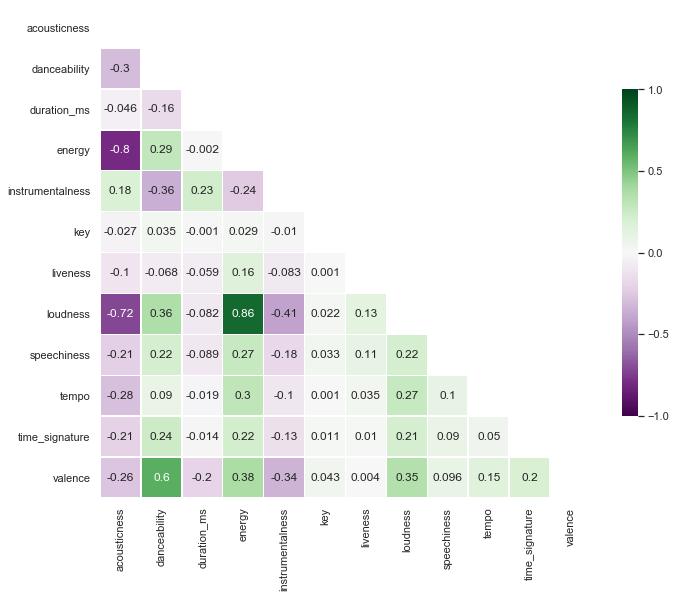

In [34]:
#spearman correlation
def corr_heatmap(data):
    corr_matrix = round(data.corr(method= 'spearman'),3)
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True
    f, ax = plt.subplots(figsize=(11, 15)) 
    heatmap = sns.heatmap(corr_matrix, 
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'PRGn',
                          cbar_kws = {'shrink': .4, 
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                          vmin = -1, 
                          vmax = 1,
                          annot = True,
                          annot_kws = {'size': 12})
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
    
features_cor=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']
sns.set(style="white")
corr_heatmap(data_full[features_cor])

#loudness, energy - high correlation with each other and acousticness, potentially will be not considered in model

In [37]:
#scaling data
scaler=StandardScaler()
data_full[features_all]= scaler.fit_transform(data_full[features_all])

c:\users\roksa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\roksa\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
#test and train set
x = data_full.drop(columns=['genre']) 
y = data_full[['genre', 'track_id']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

K-means

In [40]:


np.random.seed(1)
WSS=[]
sil=[]
ch=[]
km_seeds_list=[]
for k in range(2,8):
    km=KMeans(n_clusters=k).fit(x_test[features])
    km_labels=km.labels_
    km_seeds_list.append(km.cluster_centers_)
    
    WSS.append(km.inertia_)
    sil.append(silhouette_score(x_test[features],km_labels, metric='euclidean'))
    ch.append(calinski_harabasz_score(x_test[features], km_labels))



In [43]:
num_clust=[2,3,4,5,6,7]
sns.set(style="darkgrid")

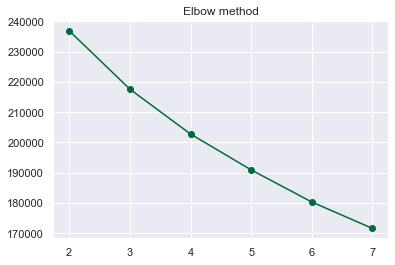

In [44]:
plt.scatter(num_clust, WSS, color='#006a3c')
plt.plot(num_clust, WSS, color='#006a3c')
plt.title('Elbow method')
plt.show()

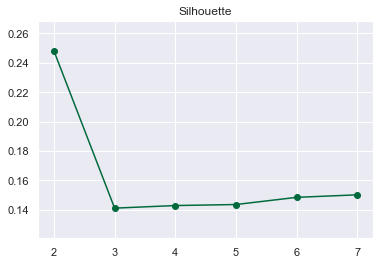

In [45]:
plt.scatter(num_clust, sil, color='#006a3c')
plt.plot(num_clust, sil, color='#006a3c')
plt.title('Silhouette')
plt.show()

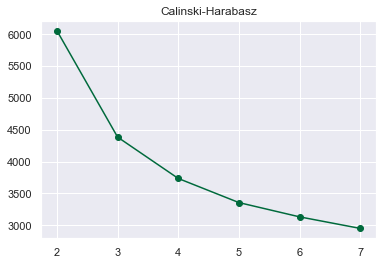

In [46]:
plt.scatter(num_clust, ch, color='#006a3c')
plt.plot(num_clust, ch, color='#006a3c')
plt.title('Calinski-Harabasz')
plt.show()

In [47]:
n_clust= 3
kmeans = KMeans(init="k-means++",
                n_clusters=n_clust,n_init=50, max_iter=500,
                random_state=1).fit(x_test[features])

In [48]:
x_test_clusters=x_test.copy().reset_index(drop=True)
x_test_clusters['kmeans'] = kmeans.labels_
x_test_clusters['kmeans_clust_freq']= x_test_clusters.groupby('kmeans').track_id.transform('count')

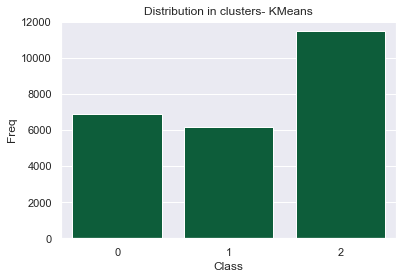

In [49]:
#distribution in cluster
km_cluster_size = x_test_clusters.groupby('kmeans').size().reset_index(name='kmeans_clust_freq')
sns.barplot(data= km_cluster_size, x='kmeans', y='kmeans_clust_freq', color='#006a3c')
plt.title('Distribution in clusters- KMeans')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.show()

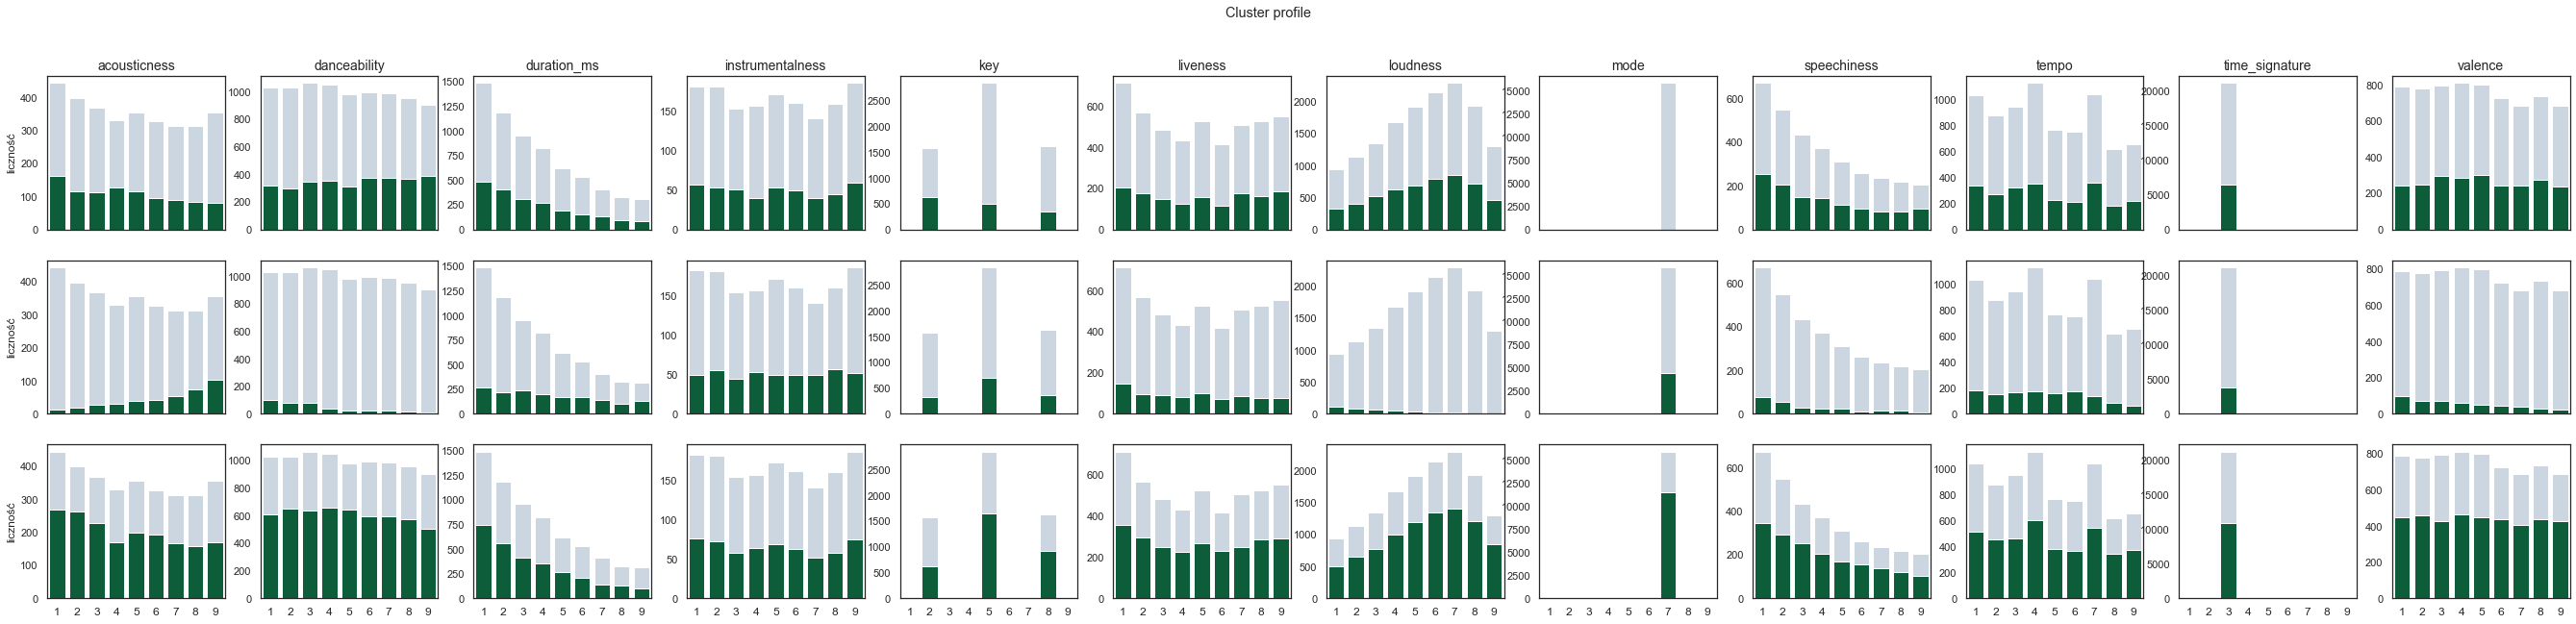

In [50]:
sns.set(style="white")
bins = np.linspace(0,1,10)

# create subplots
num_features = len(features)
num_clusters = n_clust
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(47, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(x_test_clusters['kmeans'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = x_test_clusters[x_test_clusters['kmeans'] == cluster]
    col = 0
    
    for feature in features:
#         create binned count for all recent df and clustered df
        rec_grp = x_test_clusters.groupby(pd.cut(x_test_clusters[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='#c8d6e5', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='#006a3c', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('liczność', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Cluster profile')
#plt.savefig('fig3.pdf')    
plt.show()


In [51]:
radar_col = features + ['kmeans']

# feature average for each cluster as a radar chart
df_radar = x_test_clusters[radar_col]
df_radar = df_radar.groupby('kmeans').mean().reset_index()

In [52]:

def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    #plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    #plt.ylim(0,1)
    plt.yticks([-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8, 1,1.2,1.4,1.6,1.8, 2,2.2, 2.4], ['-1.4','-1.2','-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8', '1', '1.2','1.4','1.6','1.8', '2','2.2', '2.4'], color="grey", size=8)
    plt.ylim(-1.4,2.5)
    # Ind1
    values=dframe.loc[row].drop('kmeans').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

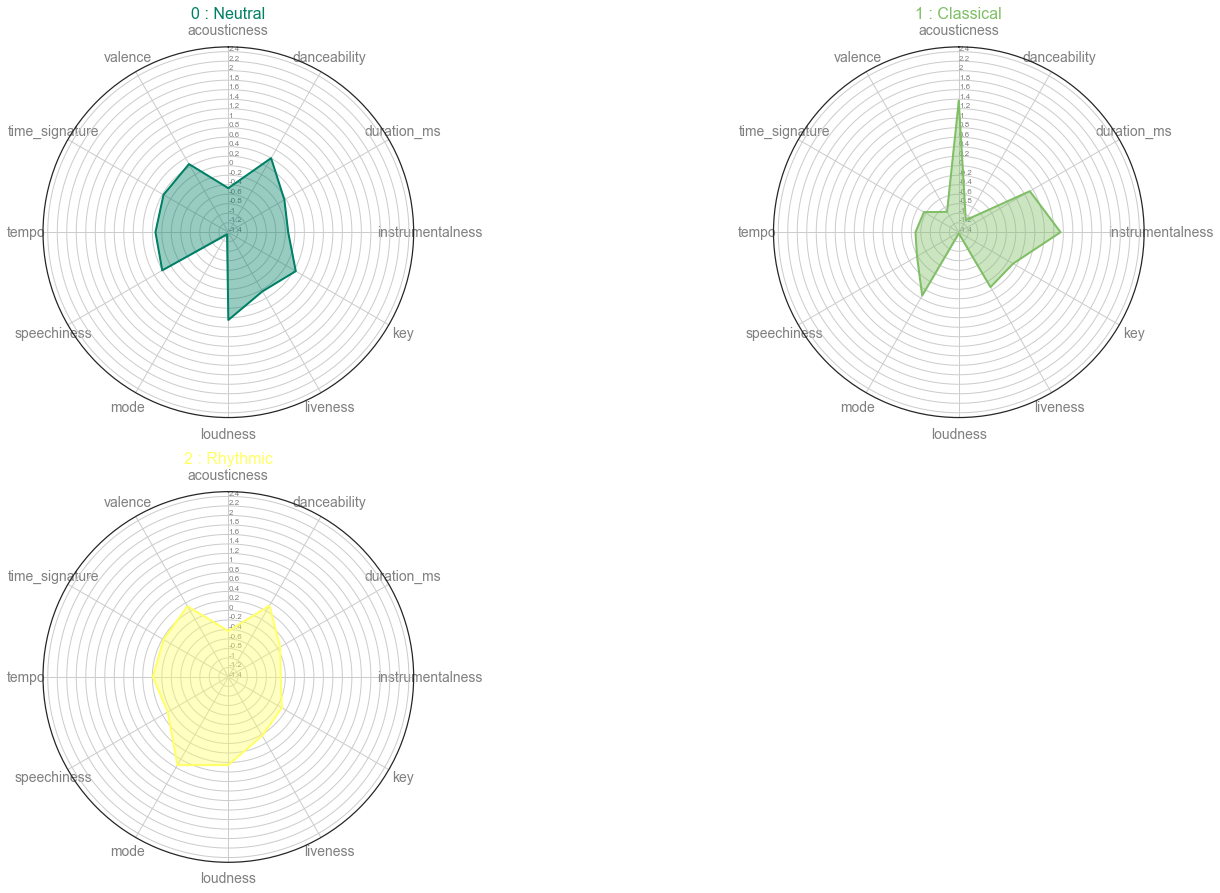

In [53]:
# initialize the figure
#p = '#173F5F', '#20639B', '#3CAEA3', '#F6D55C', '#ED553B', '#173F5F', '#173F5F'
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap('summer', len(df_radar.index))

# Create cluster name
title_list = ['Neutral', 'Classical', 'Rhythmic']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['kmeans'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

#plt.savefig('fig4_km.pdf')    
# Show plot
plt.show()

Ward

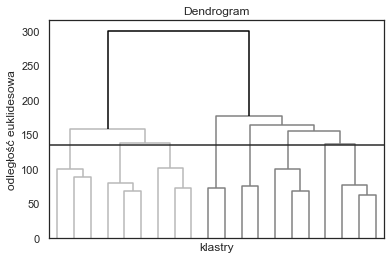

In [54]:


# dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset
sch.set_link_color_palette(["#B8B8B8",'#808080'])
dendrogram = sch.dendrogram(sch.linkage(x_test[features], metric='euclidean', method  = "ward" ), 
                            truncate_mode='lastp',  # show only the last p merged clusters
                            p=20,  # show only the last p merged clusters
                            leaf_font_size=6, above_threshold_color="#000000"
                           )
plt.title('Dendrogram')
plt.xlabel('klastry')
plt.ylabel('odległość euklidesowa')
plt.xticks([])
plt.axhline(y=135, color= '#282828' )
plt.show()


In [56]:
from sklearn.cluster import AgglomerativeClustering 
num_clust_w=2
ward = AgglomerativeClustering(n_clusters = num_clust_w, affinity = 'euclidean', linkage ='ward').fit(x_test[features])

In [57]:
num_clust_w=5
ward5 = AgglomerativeClustering(n_clusters = num_clust_w, affinity = 'euclidean', linkage ='ward').fit(x_test[features])

In [59]:
x_test_clusters['ward'] = ward.labels_
x_test_clusters['ward_clust_freq']= x_test_clusters.groupby('ward').track_id.transform('count')
x_test_clusters['ward5'] = ward5.labels_
x_test_clusters['ward_clust_freq5']= x_test_clusters.groupby('ward5').track_id.transform('count')

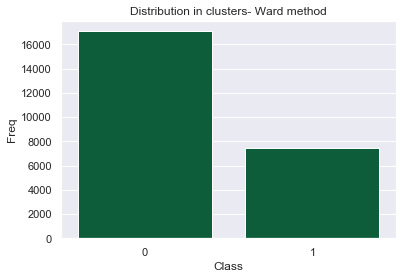

In [85]:
sns.set(style="darkgrid")
ward_cluster_size = x_test_clusters.groupby('ward').size().reset_index(name='ward_clust_freq')
sns.barplot(data= ward_cluster_size, x='ward', y='ward_clust_freq', color='#006a3c')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.title('Distribution in clusters- Ward method')
plt.show()

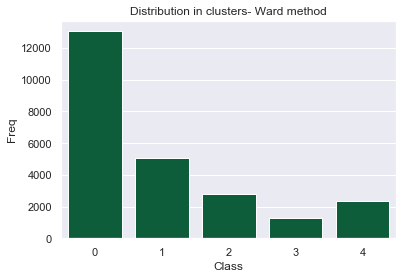

In [86]:
ward_cluster_size5 = x_test_clusters.groupby('ward5').size().reset_index(name='ward_clust_freq5')
sns.barplot(data= ward_cluster_size5, x='ward5', y='ward_clust_freq5', color='#006a3c')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.title('Distribution in clusters- Ward method')
plt.show()

In [63]:
radar_col1 = features + ['ward']

# feature average for each cluster as a radar chart
df_radar1 = x_test_clusters[radar_col1]
df_radar1 = df_radar1.groupby('ward').mean().reset_index()
df_radar1

,ward,acousticness,danceability,duration_ms,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0,-0.479811,0.334786,-0.069970,-0.168837,0.039712,0.124729,0.422462,-0.064161,0.172066,0.137271,0.246105,0.292069
1,1,1.128248,-0.796322,0.179942,0.410719,-0.088847,-0.267921,-0.990712,0.158482,-0.410131,-0.303867,-0.590365,-0.689876


In [87]:
sns.set(style="white")
def make_radar_ward(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8, 1,1.2,1.4,1.6, 1.8, 2.0, 3.0], ['-1.6','-1.4','-1.2','-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8', '1', '1.2','1.4','1.6', '1.8', '2.0', '3.0'], color="grey", size=8)
    plt.ylim(-1.6,3.2)
    #plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    #plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('ward').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

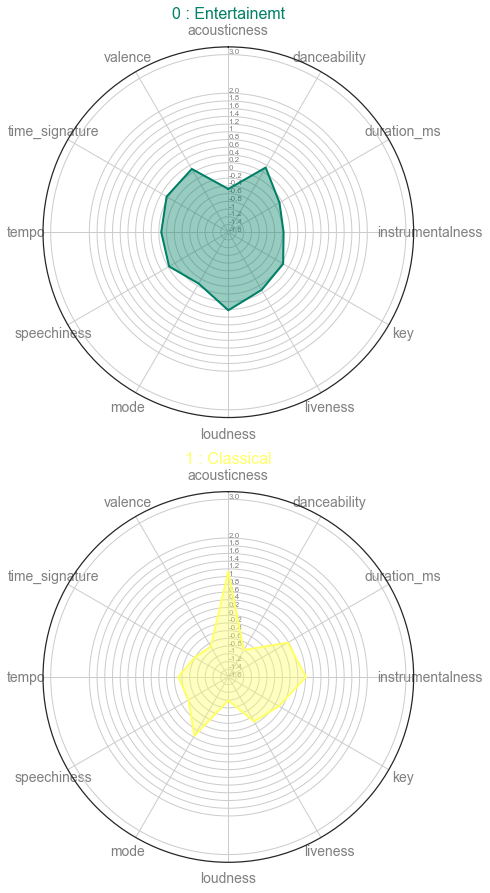

In [88]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap('summer', len(df_radar1.index))

# Create cluster name
title_list = ['Entertainemt', 'Classical']

# Loop to plot
for row in range(0, len(df_radar1.index)):
    make_radar_ward(row=row, title=str(df_radar1['ward'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar1, num_clusters=len(df_radar1.index))

    
# Show plot
plt.show()

In [71]:
x_test_clusters=x_test_clusters.merge(y_test, on='track_id')


In [72]:
x_test_clusters[x_test_clusters['kmeans'] == 0].genre.value_counts()


Electronic    1269
Reggae        1051
Rap            995
Jazz           922
Pop            789
Rock           749
Metal          710
Country        258
Classical      133
Opera           32
Name: genre, dtype: int64

In [73]:
x_test_clusters[x_test_clusters['kmeans'] == 1].genre.value_counts()

Opera         2474
Classical     2338
Jazz           641
Metal          228
Electronic     156
Rock           145
Country         82
Pop             79
Reggae           8
Rap              6
Name: genre, dtype: int64

In [74]:
x_test_clusters[x_test_clusters['kmeans'] == 2].genre.value_counts()

Country       1939
Rock          1696
Reggae        1587
Electronic    1459
Pop           1407
Rap           1224
Jazz           982
Metal          940
Classical      148
Opera           87
Name: genre, dtype: int64

In [75]:
x_test_clusters[x_test_clusters['ward'] == 0].genre.value_counts()

Electronic    2665
Reggae        2529
Rock          2198
Rap           2112
Pop           1860
Country       1713
Jazz          1619
Metal         1617
Opera          403
Classical      377
Name: genre, dtype: int64

In [76]:
x_test_clusters[x_test_clusters['ward'] == 1].genre.value_counts()

Classical     2242
Opera         2190
Jazz           926
Country        566
Pop            415
Rock           392
Metal          261
Electronic     219
Reggae         117
Rap            113
Name: genre, dtype: int64

KNN

In [77]:

knn_classifier = KNeighborsClassifier(n_neighbors=5).fit(x_train[features], y_train['genre'])
y_pred_knn = knn_classifier.predict(x_test[features])

<Figure size 1440x864 with 0 Axes>

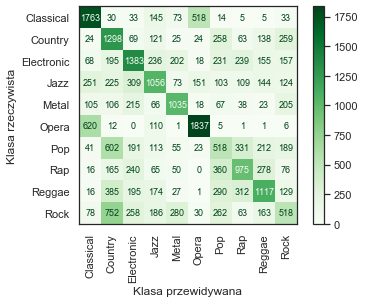

In [80]:
rcParams.update({'font.size': 9})
plt.figure(figsize=(20, 12))
plot_confusion_matrix(knn_classifier, x_test[features], y_test['genre'], cmap=plt.cm.Greens, xticks_rotation='vertical' ) 
plt.xlabel("Predicted class")
plt.ylabel("Real class")
#plt.savefig('knnconfm.pdf', bbox_inches = 'tight')
plt.show()

In [83]:
print(classification_report(y_test['genre'], y_pred_knn))
print(accuracy_score(y_test['genre'], y_pred_knn))

              precision    recall  f1-score   support

   Classical       0.59      0.67      0.63      2619
     Country       0.34      0.57      0.43      2279
  Electronic       0.48      0.48      0.48      2884
        Jazz       0.46      0.41      0.44      2545
       Metal       0.57      0.55      0.56      1878
       Opera       0.70      0.71      0.70      2593
         Pop       0.25      0.23      0.24      2275
         Rap       0.46      0.44      0.45      2225
      Reggae       0.50      0.42      0.46      2646
        Rock       0.31      0.20      0.24      2590

    accuracy                           0.47     24534
   macro avg       0.47      0.47      0.46     24534
weighted avg       0.47      0.47      0.46     24534

0.4687372625743866


In [89]:

# Create range of values for parameter
param_range = np.arange(1, 60, 2)

# Calculate accuracy on training and test set using range of parameter values
knn_train_scores, knn_test_scores = validation_curve(KNeighborsClassifier(), 
                                             x_train[features], 
                                             y_train['genre'], 
                                             param_name="n_neighbors", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


In [90]:
# Calculate mean and standard deviation for training set scores
knn_train_mean = np.mean(knn_train_scores, axis=1)
knn_train_std = np.std(knn_train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
knn_test_mean = np.mean(knn_test_scores, axis=1)
knn_test_std = np.std(knn_test_scores, axis=1)


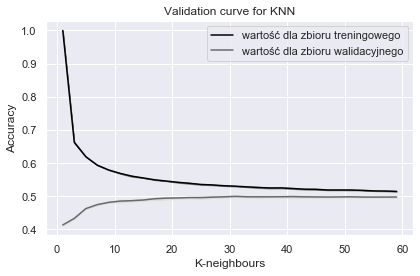

In [91]:
# Plot mean accuracy scores for training and test sets
sns.set(style="darkgrid")
plt.plot(param_range, knn_train_mean, label="wartość dla zbioru treningowego", color="black")
plt.plot(param_range, knn_test_mean, label="wartość dla zbioru walidacyjnego", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, knn_train_mean - knn_train_std, knn_train_mean + knn_train_std, color="gray")
plt.fill_between(param_range, knn_test_mean - knn_test_std, knn_test_mean + knn_test_std, color="gainsboro")

# Create plot
plt.title("Validation curve for KNN")
plt.xlabel("K-neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")
#plt.savefig('knnaccuracy.pdf')   
plt.show()

Text(0, 0.5, 'Classification error')

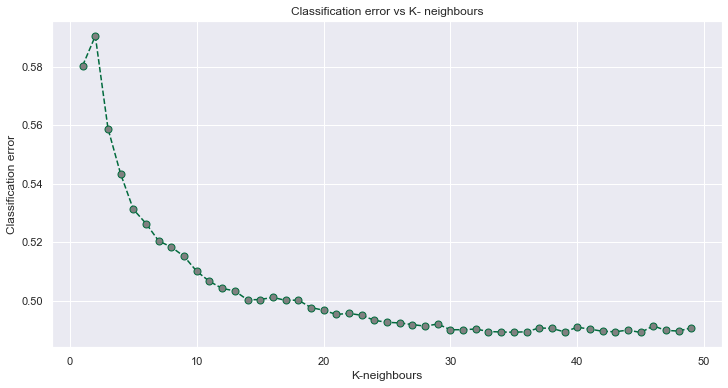

In [92]:
#prediction error vs k neighbours
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i).fit(x_train[features], y_train['genre'])
    pred_i = knn.predict(x_test[features])
    error.append(np.mean(pred_i != y_test['genre']))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), error, color='#006a3c', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=7)
plt.title('Classification error vs K- neighbours')
plt.xlabel('K-neighbours')
plt.ylabel('Classification error')
#plt.savefig('knnaerr6r.pdf') 

In [93]:
#final knn
knn_classifier2 = KNeighborsClassifier(n_neighbors=36).fit(x_train[features], y_train['genre'])
y_pred_knn2 = knn_classifier2.predict(x_test[features])

print(classification_report(y_test['genre'], y_pred_knn2))
print(accuracy_score(y_test['genre'], y_pred_knn2))

              precision    recall  f1-score   support

   Classical       0.59      0.67      0.63      2619
     Country       0.34      0.57      0.43      2279
  Electronic       0.48      0.48      0.48      2884
        Jazz       0.46      0.41      0.44      2545
       Metal       0.57      0.55      0.56      1878
       Opera       0.70      0.71      0.70      2593
         Pop       0.25      0.23      0.24      2275
         Rap       0.46      0.44      0.45      2225
      Reggae       0.50      0.42      0.46      2646
        Rock       0.31      0.20      0.24      2590

    accuracy                           0.47     24534
   macro avg       0.47      0.47      0.46     24534
weighted avg       0.47      0.47      0.46     24534

0.5105160185864515


In [94]:
# drzewo decyzyjne

tree_classifier = tree.DecisionTreeClassifier(random_state=1, max_depth=9, min_samples_split=4, min_samples_leaf=1).fit(x_train[features], y_train['genre'])
y_pred_tree = tree_classifier.predict(x_test[features])

In [95]:
print(accuracy_score(y_test['genre'], y_pred_tree))

0.5148365533545284


In [96]:
param_range1 = np.arange(1, 30, 2)

# Calculate accuracy on training and test set using range of parameter values
tr_train_scores, tr_test_scores = validation_curve(DecisionTreeClassifier(), 
                                             x_train[features], 
                                             y_train['genre'], 
                                             param_name="max_depth", 
                                             param_range=param_range1,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)
# Calculate mean and standard deviation for training set scores
tr_train_mean = np.mean(tr_train_scores, axis=1)
tr_train_std = np.std(tr_train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
tr_test_mean = np.mean(tr_test_scores, axis=1)
tr_test_std = np.std(tr_test_scores, axis=1)


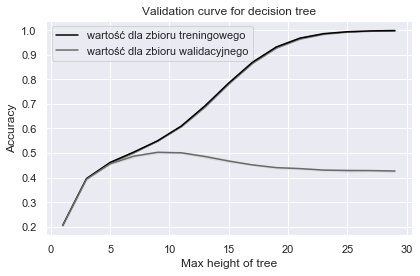

In [97]:
# Plot mean accuracy scores for training and test sets
plt.plot(param_range1, tr_train_mean, label="wartość dla zbioru treningowego", color="black")
plt.plot(param_range1, tr_test_mean, label="wartość dla zbioru walidacyjnego", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range1, tr_train_mean - tr_train_std, tr_train_mean + tr_train_std, color="gray")
plt.fill_between(param_range1, tr_test_mean - tr_test_std, tr_test_mean + tr_test_std, color="gainsboro")

# Create plot
plt.title("Validation curve for decision tree")
plt.xlabel("Max height of tree")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")
#plt.savefig('treeaccuracy.pdf')   
plt.show()

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

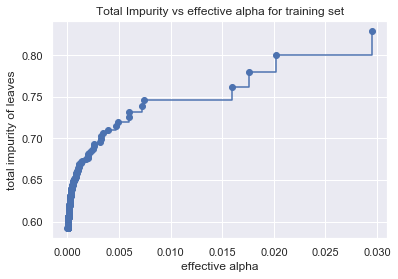

In [98]:
path = tree_classifier.cost_complexity_pruning_path(x_train[features], y_train['genre'])
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [99]:
clfs=[]
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=1, max_depth=9, min_samples_split=4, ccp_alpha=ccp_alpha).fit(x_train[features], y_train['genre'])
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06943143625660742


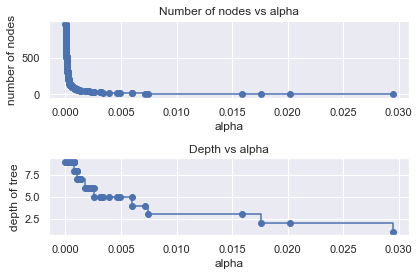

In [100]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [101]:
train_scores = [clf.score(x_train[features], y_train['genre']) for clf in clfs]
test_scores = [clf.score(x_test[features], y_test['genre']) for clf in clfs]



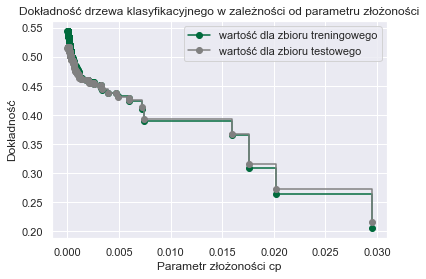

In [102]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs complexity parameter")
ax.plot(ccp_alphas, train_scores, marker='o', label="train set",
        drawstyle="steps-post", color='#006a3c')
ax.plot(ccp_alphas, test_scores, marker='o', label="validation set",
        drawstyle="steps-post", color='grey')
ax.set_xlabel("Complexity parameter")
ax.set_ylabel("Accuracy")
ax.legend()
#plt.savefig('cpalpha.pdf') 
plt.show()

In [103]:
#final
tree3 = tree.DecisionTreeClassifier(random_state=1, max_depth=9, min_samples_split=4, ccp_alpha=0.0000025).fit(x_train[features], y_train['genre'])
y_pred_tree3 = tree3.predict(x_test[features])


In [104]:
print(classification_report(y_test['genre'], y_pred_tree3))
print(accuracy_score(y_test['genre'], y_pred_tree3))

              precision    recall  f1-score   support

   Classical       0.68      0.68      0.68      2619
     Country       0.47      0.57      0.51      2279
  Electronic       0.53      0.57      0.55      2884
        Jazz       0.45      0.52      0.48      2545
       Metal       0.67      0.60      0.63      1878
       Opera       0.76      0.69      0.72      2593
         Pop       0.31      0.17      0.22      2275
         Rap       0.51      0.51      0.51      2225
      Reggae       0.43      0.48      0.46      2646
        Rock       0.32      0.34      0.33      2590

    accuracy                           0.51     24534
   macro avg       0.51      0.51      0.51     24534
weighted avg       0.51      0.51      0.51     24534

0.5148365533545284


<Figure size 1440x864 with 0 Axes>

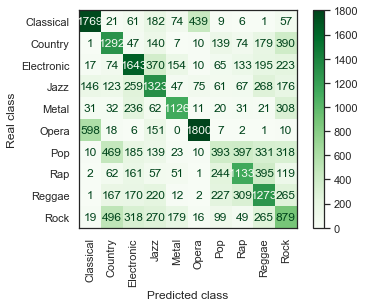

In [105]:
sns.set(style="white")
plt.figure(figsize=(20, 12))
plot_confusion_matrix(tree3, x_test[features], y_test['genre'], cmap=plt.cm.Greens, xticks_rotation='vertical') 
plt.xlabel("Predicted class")
plt.ylabel("Real class")
#plt.savefig('trconfm.pdf', bbox_inches = 'tight')
plt.show()

In [107]:

rf = RandomForestClassifier(max_depth=20, random_state=1).fit(x_train[features], y_train['genre'])
y_pred_rf = rf.predict(x_test[features])

In [108]:
param_range2 = np.arange(1, 10, 2)

# Calculate accuracy on training and test set using range of parameter values
rf_train_scores, rf_test_scores = validation_curve(RandomForestClassifier(), 
                                             x_train[features], 
                                             y_train['genre'], 
                                             param_name="min_samples_split", 
                                             param_range=param_range2,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

In [109]:
# Calculate mean and standard deviation for training set scores
rf_train_mean = np.mean(rf_train_scores, axis=1)
rf_train_std = np.std(rf_train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
rf_test_mean = np.mean(rf_test_scores, axis=1)
rf_test_std = np.std(rf_test_scores, axis=1)


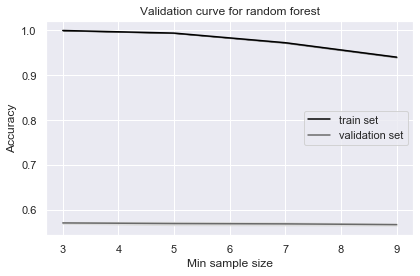

In [110]:
# Plot mean accuracy scores for training and test sets
sns.set(style="darkgrid")
plt.plot(param_range2, rf_train_mean, label="train set", color="black")
plt.plot(param_range2, rf_test_mean, label="validation set", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range2, rf_train_mean - rf_train_std, rf_train_mean + rf_train_std, color="gray")
plt.fill_between(param_range2, rf_test_mean - rf_test_std, rf_test_mean + rf_test_std, color="gainsboro")

# Create plot
plt.title("Validation curve for random forest")
plt.xlabel("Min sample size")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")
#plt.savefig('rf_minsample_accuracy.pdf')   
plt.show()

In [111]:
rf2 = RandomForestClassifier(max_depth=18, min_samples_split=2, n_estimators=100 , random_state=1).fit(x_train[features], y_train['genre'])
y_pred_rf2 = rf2.predict(x_test[features])

In [112]:
print(classification_report(y_test['genre'], y_pred_rf2))
print(accuracy_score(y_test['genre'], y_pred_rf2))


              precision    recall  f1-score   support

   Classical       0.70      0.71      0.71      2619
     Country       0.50      0.62      0.55      2279
  Electronic       0.62      0.64      0.63      2884
        Jazz       0.54      0.58      0.56      2545
       Metal       0.68      0.69      0.69      1878
       Opera       0.78      0.76      0.77      2593
         Pop       0.39      0.26      0.31      2275
         Rap       0.55      0.59      0.57      2225
      Reggae       0.55      0.55      0.55      2646
        Rock       0.40      0.37      0.38      2590

    accuracy                           0.58     24534
   macro avg       0.57      0.58      0.57     24534
weighted avg       0.57      0.58      0.57     24534

0.5774843074916443


<Figure size 1440x864 with 0 Axes>

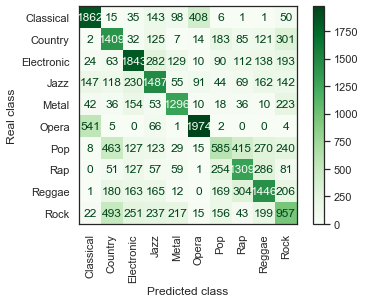

In [113]:
sns.set(style="white")
plt.figure(figsize=(20, 12))
plot_confusion_matrix(rf2, x_test[features], y_test['genre'], cmap=plt.cm.Greens, xticks_rotation='vertical') 
plt.xlabel("Predicted class")
plt.ylabel("Real class")
#plt.savefig('rfconfm.pdf', bbox_inches = 'tight')
plt.show()

In [114]:
#class to int  for gridsearch
y_train2=y_train.copy()
genre_dict = {'Electronic':0, 'Pop':1, 'Rap':2, 'Rock':3, 'Country':4, 'Reggae':5, 'Classical':6, 'Jazz':7, 'Opera':8, 'Metal':9}
y_train2['genre'] = y_train2['genre'].replace(genre_dict).astype(int)
y_test2=y_test.copy()
genre_dict = {'Electronic':0, 'Pop':1, 'Rap':2, 'Rock':3, 'Country':4, 'Reggae':5, 'Classical':6, 'Jazz':7, 'Opera':8, 'Metal':9}
y_test2['genre'] = y_test2['genre'].replace(genre_dict).astype(int)


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [35, 40, 45, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7],
    'n_estimators': [300, 400, 500, 600]
}
# Create a based model
rf3 = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf3, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train[features], y_train2['genre'])
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test[features], y_test2['genre'])

In [115]:
rf3 = RandomForestClassifier(max_depth=45, min_samples_split=5, n_estimators=500 , random_state=1).fit(x_train[features], y_train['genre'])
y_pred_rf3 = rf3.predict(x_test[features])

In [116]:
print(accuracy_score(y_test['genre'], y_pred_rf))
print(accuracy_score(y_test['genre'], y_pred_rf3))

0.5800929322572757
0.5810304067824243


In [117]:
print(classification_report(y_test['genre'], y_pred_rf3))

              precision    recall  f1-score   support

   Classical       0.71      0.71      0.71      2619
     Country       0.51      0.60      0.55      2279
  Electronic       0.62      0.64      0.63      2884
        Jazz       0.54      0.60      0.57      2545
       Metal       0.68      0.70      0.69      1878
       Opera       0.78      0.76      0.77      2593
         Pop       0.40      0.27      0.32      2275
         Rap       0.56      0.60      0.58      2225
      Reggae       0.56      0.55      0.55      2646
        Rock       0.39      0.37      0.38      2590

    accuracy                           0.58     24534
   macro avg       0.58      0.58      0.58     24534
weighted avg       0.58      0.58      0.58     24534



<Figure size 1440x864 with 0 Axes>

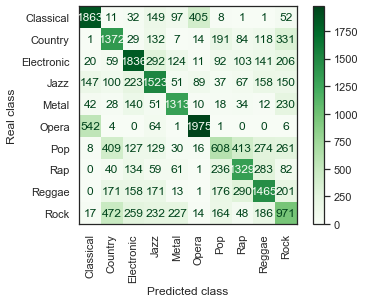

In [118]:
sns.set(style="white")
plt.figure(figsize=(20, 12))
plot_confusion_matrix(rf3, x_test[features], y_test['genre'], cmap=plt.cm.Greens, xticks_rotation='vertical') 
plt.xlabel("Predicted class")
plt.ylabel("Real class")
#plt.savefig('rfconfm.pdf', bbox_inches = 'tight')
plt.show()

In [119]:

mlp = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10).fit(x_train[features], y_train['genre'])
y_pred_mlp = mlp.predict(x_test[features])
print(classification_report(y_test['genre'], y_pred_mlp))

              precision    recall  f1-score   support

   Classical       0.65      0.73      0.69      2619
     Country       0.46      0.67      0.55      2279
  Electronic       0.63      0.58      0.60      2884
        Jazz       0.55      0.53      0.54      2545
       Metal       0.66      0.64      0.65      1878
       Opera       0.76      0.69      0.73      2593
         Pop       0.36      0.25      0.30      2275
         Rap       0.52      0.60      0.56      2225
      Reggae       0.56      0.54      0.55      2646
        Rock       0.38      0.34      0.36      2590

    accuracy                           0.56     24534
   macro avg       0.55      0.56      0.55     24534
weighted avg       0.56      0.56      0.55     24534



In [120]:
print(accuracy_score(y_test['genre'], y_pred_mlp))

0.5568598679383713


In [121]:
#binary
Y_binary = tf.keras.utils.to_categorical(y_train2['genre'], dtype='int')
Y_binary_test = tf.keras.utils.to_categorical(y_test2['genre'], dtype='int')

In [122]:
x_train_re = np.asarray(x_train[features_all]).reshape(-1, 13,1)
x_test_re = np.asarray(x_test[features_all]).reshape(-1, 13,1)

In [123]:
inputs = tf.keras.layers.Input(shape=(13, 1), dtype='float32', name='input_layer')
conv = tf.keras.layers.Conv1D(64, 13, activation="relu", input_shape=(13, 1), name='conv_layer')(inputs) 
pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1)(conv)
flatten = tf.keras.layers.Flatten()(pool)
outputs = tf.keras.layers.Dense(64, activation='relu', name='hidden_layer')(flatten)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(outputs) 

In [124]:
# Create a model from input layer and output layers
model_cnn = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='neural_network')
    # Compile the model (binary_crossentropy if 2 classes)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
model_cnn.summary()

Model: "neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 13, 1)]           0         
_________________________________________________________________
conv_layer (Conv1D)          (None, 1, 64)             896       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
hidden_layer (Dense)         (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 10)                650       
Total params: 5,706
Trainable params: 5,706
Non-trainable params: 0
__________________________________________________

In [126]:
 # Train the model on the train set (output debug information)
history=model_cnn.fit(x_train_re, Y_binary, batch_size=10, epochs=10, validation_split=.2,verbose=1)

Epoch 1/10
4580/4580 [==============================] - 5s 1ms/step - loss: 1.3621 - accuracy: 0.5024 - val_loss: 1.2843 - val_accuracy: 0.5352
Epoch 2/10
4580/4580 [==============================] - 5s 1ms/step - loss: 1.2786 - accuracy: 0.5329 - val_loss: 1.2638 - val_accuracy: 0.5364
Epoch 3/10
4580/4580 [==============================] - 5s 1ms/step - loss: 1.2544 - accuracy: 0.5412 - val_loss: 1.2406 - val_accuracy: 0.5451
Epoch 4/10
4580/4580 [==============================] - 6s 1ms/step - loss: 1.2376 - accuracy: 0.5473 - val_loss: 1.2325 - val_accuracy: 0.5505
Epoch 5/10
4580/4580 [==============================] - 6s 1ms/step - loss: 1.2238 - accuracy: 0.5528 - val_loss: 1.2278 - val_accuracy: 0.5493
Epoch 6/10
4580/4580 [==============================] - 6s 1ms/step - loss: 1.2148 - accuracy: 0.5546 - val_loss: 1.2173 - val_accuracy: 0.5548
Epoch 7/10
4580/4580 [==============================] - 6s 1ms/step - loss: 1.2054 - accuracy: 0.5600 - val_loss: 1.2172 - val_accuracy:

[Text(0, 0.5, 'dokładność'), Text(0.5, 0, 'epochs')]

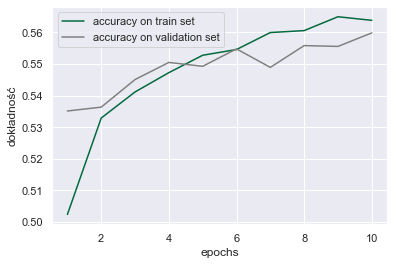

In [127]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
ax.plot(range(1,11), history.history['accuracy'], label='accuracy on train set', color= '#006a3c')
ax.plot(range(1,11), history.history['val_accuracy'], label='accuracy on validation set', color='grey')
ax.legend(loc='best')
ax.set(xlabel='epochs', ylabel='dokładność')

In [128]:
y_pred_nn2 = model_cnn.predict(x_test[features_all])

In [129]:
test_loss, test_acc = model_cnn.evaluate(x_test[features_all],  Y_binary_test, verbose=1)

767/767 [==============================] - 1s 977us/step - loss: 1.2006 - accuracy: 0.5622


In [130]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow_addons.layers import WeightNormalization

inputs = Input(shape=(len(features_all),), dtype='float32', name='input_layer') 
layer = WeightNormalization(Dense(64, activation='relu'))(inputs) 
layer = WeightNormalization(Dense(128, activation='relu'))(layer)
layer = Dropout(0.25)(layer)
layer = WeightNormalization(Dense(256, activation='relu'))(layer)
layer = Dropout(0.35)(layer)
layer = WeightNormalization(Dense(512, activation='relu'))(layer) 
layer = Dropout(0.35)(layer)
layer = WeightNormalization(Dense(256, activation='relu'))(layer) 
layer = Dropout(0.25)(layer)
layer = WeightNormalization(Dense(128, activation='relu'))(layer) 
layer = WeightNormalization(Dense(64, activation='relu'))(layer) 
outputs = Dense(10, activation='softmax', name='output_layer')(layer) 

# Create a model from input layer and output layers
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='neural_network')
    
sgd = tf.keras.optimizers.SGD(learning_rate=0.009, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [131]:
BS = 200
EPOCHS = 120

history2 = model.fit(x_train[features_all], Y_binary, batch_size=BS, epochs=EPOCHS, verbose=1, validation_split=.2)

Epoch 1/120
229/229 [==============================] - 3s 12ms/step - loss: 1.6319 - accuracy: 0.3962 - val_loss: 1.3563 - val_accuracy: 0.5156
Epoch 2/120
229/229 [==============================] - 2s 11ms/step - loss: 1.3979 - accuracy: 0.4909 - val_loss: 1.3341 - val_accuracy: 0.5184
Epoch 3/120
229/229 [==============================] - 2s 9ms/step - loss: 1.3637 - accuracy: 0.5074 - val_loss: 1.3015 - val_accuracy: 0.5319
Epoch 4/120
229/229 [==============================] - 2s 9ms/step - loss: 1.3434 - accuracy: 0.5168 - val_loss: 1.2906 - val_accuracy: 0.5326
Epoch 5/120
229/229 [==============================] - 2s 10ms/step - loss: 1.3297 - accuracy: 0.5224 - val_loss: 1.2929 - val_accuracy: 0.5269
Epoch 6/120
229/229 [==============================] - 2s 10ms/step - loss: 1.3208 - accuracy: 0.5231 - val_loss: 1.2821 - val_accuracy: 0.5340
Epoch 7/120
229/229 [==============================] - 2s 10ms/step - loss: 1.3130 - accuracy: 0.5274 - val_loss: 1.2774 - val_accuracy: 0

229/229 [==============================] - 3s 12ms/step - loss: 1.1836 - accuracy: 0.5706 - val_loss: 1.2085 - val_accuracy: 0.5626
Epoch 58/120
229/229 [==============================] - 3s 12ms/step - loss: 1.1828 - accuracy: 0.5715 - val_loss: 1.2112 - val_accuracy: 0.5597
Epoch 59/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1828 - accuracy: 0.5721 - val_loss: 1.2119 - val_accuracy: 0.5578
Epoch 60/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1851 - accuracy: 0.5738 - val_loss: 1.2088 - val_accuracy: 0.5621
Epoch 61/120
229/229 [==============================] - 3s 12ms/step - loss: 1.1775 - accuracy: 0.5736 - val_loss: 1.2105 - val_accuracy: 0.5618
Epoch 62/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1802 - accuracy: 0.5724 - val_loss: 1.2184 - val_accuracy: 0.5578
Epoch 63/120
229/229 [==============================] - 3s 12ms/step - loss: 1.1806 - accuracy: 0.5725 - val_loss: 1.2121 - val_accuracy: 0.560

229/229 [==============================] - 3s 13ms/step - loss: 1.1374 - accuracy: 0.5863 - val_loss: 1.2109 - val_accuracy: 0.5616
Epoch 114/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1378 - accuracy: 0.5854 - val_loss: 1.2044 - val_accuracy: 0.5636
Epoch 115/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1360 - accuracy: 0.5878 - val_loss: 1.2068 - val_accuracy: 0.5644
Epoch 116/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1370 - accuracy: 0.5856 - val_loss: 1.2115 - val_accuracy: 0.5628
Epoch 117/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1384 - accuracy: 0.5871 - val_loss: 1.2101 - val_accuracy: 0.5618
Epoch 118/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1376 - accuracy: 0.5866 - val_loss: 1.2087 - val_accuracy: 0.5593
Epoch 119/120
229/229 [==============================] - 3s 13ms/step - loss: 1.1352 - accuracy: 0.5882 - val_loss: 1.2108 - val_accuracy:

In [132]:
test_loss, test_acc = model.evaluate(x_test[features_all],  Y_binary_test, batch_size=BS, verbose=1)

123/123 [==============================] - 0s 4ms/step - loss: 1.1962 - accuracy: 0.5678


[Text(0, 0.5, 'dokładność'), Text(0.5, 0, 'epochs')]

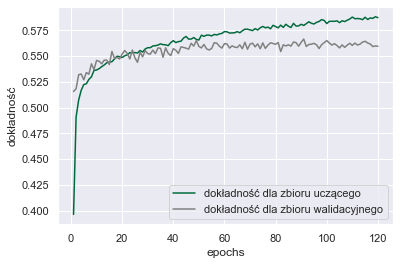

In [133]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
ax.plot(range(1,121), history2.history['accuracy'], label='dokładność dla zbioru uczącego', color= '#006a3c')
ax.plot(range(1,121), history2.history['val_accuracy'], label='dokładność dla zbioru walidacyjnego', color='grey')
ax.legend(loc='best')
ax.set(xlabel='epochs', ylabel='dokładność')

In [134]:
predictions = model.predict(x_test[features_all])

In [135]:
print(sklearn.metrics.classification_report(y_test2['genre'], np.argmax(predictions, axis=1)))
print(sklearn.metrics.accuracy_score(y_test2['genre'], np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      2884
           1       0.37      0.28      0.32      2275
           2       0.53      0.58      0.56      2225
           3       0.39      0.34      0.36      2590
           4       0.48      0.64      0.55      2279
           5       0.55      0.59      0.57      2646
           6       0.72      0.64      0.68      2619
           7       0.54      0.57      0.55      2545
           8       0.74      0.78      0.76      2593
           9       0.70      0.68      0.69      1878

    accuracy                           0.57     24534
   macro avg       0.56      0.57      0.56     24534
weighted avg       0.57      0.57      0.56     24534

0.5678242439064156


In [136]:
cm=pd.DataFrame(confusion_matrix(y_test2['genre'], np.argmax(predictions, axis=1)))
cm

,0,1,2,3,4,5,6,7,8,9
0,1684,148,175,228,74,144,15,280,9,127
1,121,643,390,179,472,303,6,126,14,21
2,128,258,1294,78,53,329,0,50,0,35
3,218,188,75,869,623,189,6,214,14,194
4,17,194,81,244,1450,125,2,149,10,7
5,102,197,284,156,176,1559,0,162,0,10
6,38,6,2,44,12,1,1679,160,571,106
7,206,75,96,169,113,164,117,1460,91,54
8,0,5,0,0,0,0,487,77,2024,0
9,135,16,29,283,46,15,27,41,17,1269
